## Feature Selection

**What is Feature Selection?**

Feature selection is the process of choosing a subset of relevant features (or input columns of data) from the full set of available features in a dataset. Each feature represents a dimension of the data, and selecting the most important ones helps improve the performance and efficiency of machine learning models. By focusing on key features, feature selection reduces computational complexity, minimizes overfitting, and enhances model interpretability. It is a crucial step in the machine learning workflow, ensuring that the model uses only the most impactful data to make accurate predictions or classifications.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-activity-recognition-with-smartphones/train.csv
/kaggle/input/human-activity-recognition-with-smartphones/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest



In [3]:
df_train = pd.read_csv('/kaggle/input/human-activity-recognition-with-smartphones/train.csv')
df_test = pd.read_csv('/kaggle/input/human-activity-recognition-with-smartphones/test.csv')

In [4]:
df_train['Activity'].value_counts()

Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64

In [5]:
df_train.duplicated().sum()

0

#### Test the accuracy of model before feature selection

In [6]:
# Separate features and target
X = df_train.drop('Activity', axis=1)
y = df_train['Activity']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:

# Initialize and train logistic regression model
log_reg = LogisticRegression(max_iter=1500)  # Increase max_iter if it doesn't converge
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Calculate and print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Test accuracy: 0.981645139360979


### Resons for Features Selection

1. **Curse of Dimensionality**: As the number of features increases, the performance of machine learning algorithms often degrades. High-dimensional data introduces sparsity, making distance calculations less reliable and reducing the model's effectiveness.

2. **Computational Complexity**: Machine learning algorithms involve extensive mathematical computations. Increasing the number of features adds to the computational workload, leading to longer processing times and higher complexity. Reducing features streamlines the process.

3. **Interpretability**: An excessive number of features can make it challenging to interpret the model's results and understand its decision-making process. Simplifying the feature set enhances the clarity of the insights drawn from the model.

### Filter Based Feature Selection

Filter-based feature selection techniques are methods that use statistical measures to score each feature independently, and then select a subset of features based on these scores. The methods are called 'filter' methods because they essentially filter out the features that do not meet some criterion. Filter based feature selection are univariate analysis.

#### Step 1: Deleting Duplicate Features

In [8]:
class DuplicateColumnRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.duplicate_columns = {}
        self.retained_columns = []

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input data must be a pandas DataFrame.")

        self.duplicate_columns = self._get_duplicate_columns(X)
        self.retained_columns = [col for col in X.columns if col not in self.duplicate_columns]
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input data must be a pandas DataFrame.")

        return X[self.retained_columns]

    def get_feature_names_out(self, input_features=None):
        return self.retained_columns

    def _get_duplicate_columns(self, df):
        duplicate_columns = {}
        seen_columns = {}

        for column in df.columns:
            current_column = df[column]

            # Convert column data to bytes
            try:
                current_column_hash = current_column.values.tobytes()
            except AttributeError:
                current_column_hash = current_column.to_string().encode()

            if current_column_hash in seen_columns:
                if seen_columns[current_column_hash] in duplicate_columns:
                    duplicate_columns[seen_columns[current_column_hash]].append(column)
                else:
                    duplicate_columns[seen_columns[current_column_hash]] = [column]
            else:
                seen_columns[current_column_hash] = column

        return duplicate_columns


In [9]:
df_train.shape

(7352, 563)

In [10]:
# Instantiate the pipeline
pipeline = Pipeline([
    ('remove_duplicates', DuplicateColumnRemover()),
])

# Fit and transform the data
transformed_df_train = pipeline.fit_transform(X_train)

In [11]:
transformed_df_train.shape

(5881, 543)

In [12]:
transformed_df_test = pipeline.transform(X_test)

In [13]:
transformed_df_test.shape

(1471, 543)

#### Variance Threshold

In [14]:
transformed_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5881 entries, 57 to 7270
Columns: 543 entries, tBodyAcc-mean()-X to subject
dtypes: float64(542), int64(1)
memory usage: 24.4 MB


In [15]:

# sel = VarianceThreshold(threshold=0.05)
# sel.fit(transformed_df_train)
# sum(sel.get_support())
# columns = transformed_df_train.columns[sel.get_support()]

# transformed_df_train = sel.transform(transformed_df_train)
# transformed_df_test = sel.transform(transformed_df_test)

# transformed_df_train = pd.DataFrame(transformed_df_train, columns=columns)
# transformed_df_test = pd.DataFrame(transformed_df_test, columns=columns)

In [16]:
transformed_df_train.shape

(5881, 543)

In [17]:
transformed_df_test.shape

(1471, 543)

In [18]:
# Instantiate the pipeline
pipeline = Pipeline([
    ('remove_duplicates', DuplicateColumnRemover()),
    ('variance_threshold', VarianceThreshold(threshold=0.05)),
])

In [19]:
 pipeline.fit(X_train)

Pipeline(steps=[('remove_duplicates', DuplicateColumnRemover()),
                ('variance_threshold', VarianceThreshold(threshold=0.05))])

In [20]:
transformed_X = pipeline.transform(X_train)

In [21]:
# Get feature names after the variance threshold step
if hasattr(pipeline.named_steps['variance_threshold'], 'get_feature_names_out'):
    feature_names = pipeline.named_steps['variance_threshold'].get_feature_names_out()
    print(feature_names)
else:
    print("The final step does not support getting feature names.")

['tBodyAcc-std()-X' 'tBodyAcc-std()-Y' 'tBodyAcc-std()-Z'
 'tBodyAcc-mad()-X' 'tBodyAcc-mad()-Y' 'tBodyAcc-mad()-Z'
 'tBodyAcc-max()-X' 'tBodyAcc-max()-Y' 'tBodyAcc-max()-Z'
 'tBodyAcc-min()-X' 'tBodyAcc-min()-Y' 'tBodyAcc-min()-Z' 'tBodyAcc-sma()'
 'tBodyAcc-energy()-X' 'tBodyAcc-iqr()-X' 'tBodyAcc-iqr()-Y'
 'tBodyAcc-iqr()-Z' 'tBodyAcc-entropy()-X' 'tBodyAcc-entropy()-Y'
 'tBodyAcc-entropy()-Z' 'tBodyAcc-arCoeff()-X,1' 'tBodyAcc-arCoeff()-X,2'
 'tBodyAcc-arCoeff()-X,3' 'tBodyAcc-arCoeff()-X,4'
 'tBodyAcc-arCoeff()-Y,1' 'tBodyAcc-arCoeff()-Z,1'
 'tBodyAcc-arCoeff()-Z,3' 'tBodyAcc-arCoeff()-Z,4'
 'tBodyAcc-correlation()-X,Y' 'tBodyAcc-correlation()-X,Z'
 'tBodyAcc-correlation()-Y,Z' 'tGravityAcc-mean()-X'
 'tGravityAcc-mean()-Y' 'tGravityAcc-mean()-Z' 'tGravityAcc-max()-X'
 'tGravityAcc-max()-Y' 'tGravityAcc-max()-Z' 'tGravityAcc-min()-X'
 'tGravityAcc-min()-Y' 'tGravityAcc-min()-Z' 'tGravityAcc-sma()'
 'tGravityAcc-energy()-X' 'tGravityAcc-energy()-Y'
 'tGravityAcc-energy()-Z' 'tGravi

In [22]:
transformed_df_train = pd.DataFrame(transformed_X, columns=feature_names)

In [23]:
transformed_df_train.head()

,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
0,-0.994425,-0.994873,-0.994886,-0.994939,-0.993994,-0.995450,-0.938974,-0.577031,-0.813863,0.846922,...,-0.684497,-0.901888,0.751089,0.626432,0.263401,-0.646225,0.398881,-0.546717,-0.431200,1.0
1,-0.326331,0.069663,-0.224321,-0.343326,0.039623,-0.256327,-0.310961,0.085617,-0.411806,0.271334,...,-0.131946,-0.591721,0.628099,-0.357089,-0.925512,0.110212,-0.474013,0.383162,0.238969,21.0
2,-0.026220,-0.032163,0.393109,-0.118256,-0.030279,0.432861,0.370607,-0.072309,0.200747,0.118277,...,-0.643660,-0.935668,-0.182993,0.484857,-0.961034,0.147325,-0.819001,0.221549,-0.003571,29.0
3,-0.981092,-0.901124,-0.960423,-0.984417,-0.901405,-0.965788,-0.922291,-0.524676,-0.807362,0.825370,...,-0.326860,-0.645937,0.205896,-0.168239,-0.197557,0.328892,-0.744428,0.274256,0.031246,3.0
4,-0.997380,-0.983893,-0.984482,-0.997331,-0.985196,-0.983768,-0.942062,-0.564033,-0.810993,0.853330,...,-0.113724,-0.445144,-0.267371,-0.304399,-0.081555,0.110146,-0.615329,0.322236,0.161577,21.0


In [24]:
transformed_X_test = pipeline.transform(X_test)
transformed_df_test = pd.DataFrame(transformed_X_test, columns = feature_names)

In [25]:
transformed_df_test.head()

,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
0,0.384949,0.176898,-0.310332,0.381757,0.122611,-0.332984,0.465563,0.023174,-0.274788,-0.176416,...,-0.730593,-0.932568,-0.034924,0.558036,0.258975,-0.854858,-0.784330,0.222960,-0.066506,22.0
1,0.201409,-0.154142,0.344183,0.092771,-0.182114,0.291899,0.586004,-0.089706,-0.307547,0.201299,...,-0.032958,-0.338095,0.017986,-0.475545,0.942947,-0.567147,-0.665156,0.178975,0.243362,7.0
2,-0.336609,-0.279162,-0.303323,-0.381421,-0.253026,-0.337381,0.074430,-0.228225,-0.346372,0.339322,...,-0.351997,-0.698254,-0.044663,-0.551806,-0.680774,0.161405,-0.857202,0.192929,0.046716,27.0
3,-0.992196,-0.982169,-0.981127,-0.992838,-0.981366,-0.979864,-0.931924,-0.560341,-0.809997,0.840250,...,-0.623358,-0.906098,-0.177275,-0.309304,0.176515,-0.143818,-0.625215,-0.106678,-0.147469,21.0
4,0.075014,0.046502,-0.369482,-0.024794,-0.085337,-0.385018,0.562230,0.093312,-0.200019,0.213969,...,0.020630,-0.316113,0.347143,0.590475,0.831084,0.465453,-0.860617,0.150598,-0.067109,29.0


##### Points to Consider

1. **Ignores target variable**: Variance Threshold is a univariate method, meaning it evaluates each feature independently and doesn't consider the relationship between each feature and the target variable.
2. **Ignores Feature Interaction**: Variance Threshold doesn't account for interactions between features. A feature with a low variance may become very informative when combined with another feature
3. **Sensitive Data Scaling**: Variance Threshold is sensitive to the scale of the data. If features are not on the same scale, the variance will naturally be higher for features with larger values. Therefore, it is important to standardize the features before applying variance threshold.
4. **Arbitary Threshold Value**: It's up to the user to define what constitutes a "low" variance. The threshold is not always easy to define and the optimal value can vary between datasets.

#### Correlation Based Filter



<Axes: >

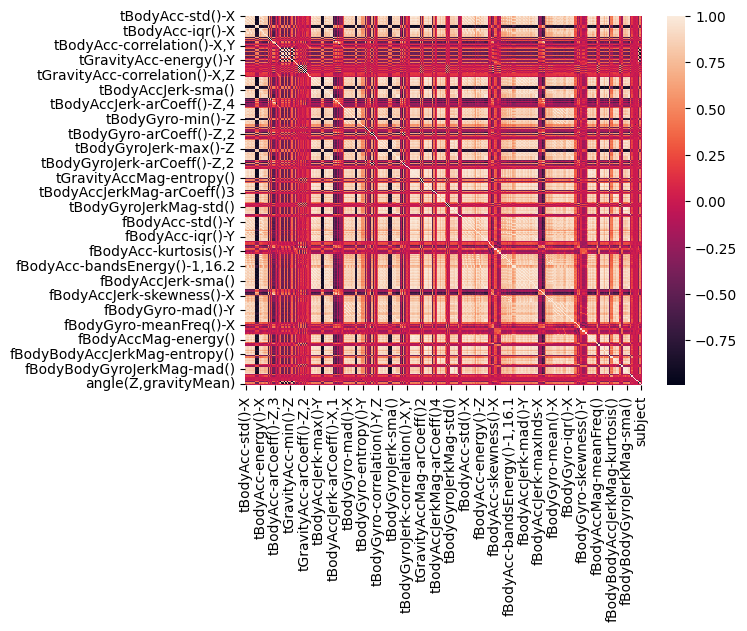

In [26]:
sns.heatmap(transformed_df_test.corr())

In [27]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationThresholdRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        """
        Initialize the CorrelationThresholdRemover.

        Parameters:
        - threshold (float): The correlation threshold above which features are considered highly correlated.
        """
        self.threshold = threshold
        self.to_remove_ = None
        self.remaining_features_ = None

    def fit(self, X, y=None):
        """
        Fit the transformer to the data.

        Parameters:
        - X (pd.DataFrame or np.ndarray): The input dataframe or array with features.
        - y: Ignored.

        Returns:
        - self
        """
        # Convert to DataFrame if necessary
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame or NumPy array.")

        # Calculate the Pearson correlation matrix
        correlation_matrix = X.corr()

        # Identify pairs of features with correlation above the threshold
        upper_triangle = correlation_matrix.where(
            np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
        )
        self.to_remove_ = [
            column for column in upper_triangle.columns
            if any(upper_triangle[column].abs() > self.threshold)
        ] 
        # Identify the remaining features
        self.remaining_features_ =  [col for col in X.columns if col not in self.to_remove_] 
        return self

    def transform(self, X):
        """
        Transform the data by removing highly correlated features.
        
        Parameters:
        - X (pd.DataFrame or np.ndarray): The input dataframe or array with features.
        
        Returns:
        - X_transformed (np.ndarray): The transformed NumPy array with less correlated features.
        """
        # If X is a NumPy array, convert it to DataFrame using the original column names
        if isinstance(X, np.ndarray):
            if self.remaining_features_ is None:
                raise ValueError("The transformer has not been fitted yet.")
            # Ensure the DataFrame column names match the original columns
            X = pd.DataFrame(X, columns=self.remaining_features_ + self.to_remove_)

        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame or NumPy array.")

        # Remove identified columns
        X_transformed = X.drop(columns=self.to_remove_, errors='ignore')

        # Return transformed data as NumPy array
        return X_transformed.to_numpy()

    def get_feature_names_out(self, input_features=None):
        """
        Get the names of the remaining features after transformation.

        Parameters:
        - input_features: Ignored (for compatibility with scikit-learn API).

        Returns:
        - list: Names of the remaining features.
        """
        if self.remaining_features_ is None:
            raise ValueError("The transformer has not been fitted yet.")
        return self.remaining_features_


In [28]:
# Instantiate the pipeline
pipeline = Pipeline([
    ('remove_duplicates', DuplicateColumnRemover()),
    ('variance_threshold', VarianceThreshold(threshold=0.05)),
    ('correlation_remover', CorrelationThresholdRemover(threshold=0.9))
])
pipeline.fit(X_train)

Pipeline(steps=[('remove_duplicates', DuplicateColumnRemover()),
                ('variance_threshold', VarianceThreshold(threshold=0.05)),
                ('correlation_remover', CorrelationThresholdRemover())])

In [29]:
transformed_X_train_2 = pipeline.transform(X_train)

In [30]:
 transformed_X_train_2

array([[-0.9944254 , -0.99487263, -0.99488582, ...,  0.03952902,
         0.14991895, -0.21788456],
       [-0.32633148,  0.0696628 , -0.22432128, ..., -0.1192726 ,
        -0.62512809,  0.66284691],
       [-0.02621997, -0.03216306,  0.39310852, ..., -0.27462703,
         0.01686076,  0.02270385],
       ...,
       [-0.62719763, -0.21656585, -0.42476369, ..., -0.30474204,
        -0.43457906,  0.30169739],
       [-0.9948248 , -0.98531367, -0.96585729, ..., -0.02684226,
         0.23553996, -0.15752001],
       [-0.36865452, -0.14263084, -0.15125003, ..., -0.54358095,
        -0.48621609,  0.43371953]])

In [31]:
feature_names_2 = pipeline.named_steps['correlation_remover'].get_feature_names_out()
feature_names = X_train.columns[feature_names_2]
feature_names
transformed_df_train_2 = pd.DataFrame(transformed_X_train_2, columns= feature_names)
transformed_df_train_2

,tBodyAcc-mean()-X,tBodyAcc-mean()-Z,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,...,"fBodyAcc-bandsEnergy()-1,16.1","fBodyAcc-bandsEnergy()-17,24.2","fBodyAcc-bandsEnergy()-25,32.2","fBodyAcc-bandsEnergy()-49,64.2","fBodyAcc-bandsEnergy()-1,24.2",fBodyAccJerk-mean()-X,fBodyAccJerk-mean()-Y,fBodyAccJerk-mean()-Z,fBodyAccJerk-std()-X,fBodyAccJerk-mad()-Y
0,-0.994425,-0.994873,-0.994886,-0.994939,-0.993994,-0.995450,-0.938974,-0.577031,-0.813863,0.846922,...,-0.896017,-0.430368,-0.622629,0.338619,-0.286959,0.478027,-0.248684,0.039529,0.149919,-0.217885
1,-0.326331,0.069663,-0.224321,-0.343326,0.039623,-0.256327,-0.310961,0.085617,-0.411806,0.271334,...,0.870400,-0.134031,0.000865,-0.287847,0.284370,-0.147217,0.051055,-0.119273,-0.625128,0.662847
2,-0.026220,-0.032163,0.393109,-0.118256,-0.030279,0.432861,0.370607,-0.072309,0.200747,0.118277,...,0.691959,-0.238478,0.200254,-0.484592,0.255857,0.285315,-0.380941,-0.274627,0.016861,0.022704
3,-0.981092,-0.901124,-0.960423,-0.984417,-0.901405,-0.965788,-0.922291,-0.524676,-0.807362,0.825370,...,0.150955,-0.220464,0.170012,-0.603770,0.389099,-0.061598,0.077252,-0.227512,-0.267228,0.091483
4,-0.997380,-0.983893,-0.984482,-0.997331,-0.985196,-0.983768,-0.942062,-0.564033,-0.810993,0.853330,...,-0.286130,-0.542528,-0.323641,-0.365228,0.284003,-0.227992,0.320761,0.315396,-0.118201,0.118660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,-0.555352,-0.104055,-0.438064,-0.572530,-0.112149,-0.429688,-0.479744,-0.077885,-0.373579,0.454289,...,0.038441,0.065154,0.306949,-0.702010,0.395776,0.384185,-0.569406,-0.649207,-0.485000,0.427826
5877,-0.290043,-0.212102,-0.469731,-0.307317,-0.209558,-0.528635,-0.283244,-0.017039,-0.123285,0.123907,...,0.156262,0.342386,0.301551,-0.557796,0.351891,0.280822,-0.398700,-0.112065,-0.342990,0.092538
5878,-0.627198,-0.216566,-0.424764,-0.648666,-0.253814,-0.417569,-0.547082,-0.236201,-0.441355,0.530629,...,0.163029,0.158676,0.096314,-0.586953,0.344516,0.293541,-0.427976,-0.304742,-0.434579,0.301697
5879,-0.994825,-0.985314,-0.965857,-0.995170,-0.984285,-0.963293,-0.937503,-0.570198,-0.805684,0.849776,...,-0.429390,-0.479023,-0.448591,0.294839,-0.252193,0.368755,-0.043055,-0.026842,0.235540,-0.157520


In [32]:
transformed_X_test_2 = pipeline.transform(X_test)
transformed_X_test_2

array([[ 0.38494871,  0.17689788, -0.31033164, ...,  0.39697892,
        -0.10232202,  0.11069439],
       [ 0.20140924, -0.15414164,  0.34418337, ..., -0.23175949,
        -0.3824228 ,  0.42281556],
       [-0.33660882, -0.2791625 , -0.30332258, ..., -0.06559701,
        -0.32147301,  0.25748147],
       ...,
       [-0.99419848, -0.98832935, -0.99061824, ..., -0.00244964,
         0.26322655, -0.26440074],
       [-0.99751703, -0.9822074 , -0.97434282, ...,  0.05321243,
         0.52581888, -0.43997637],
       [-0.99718339, -0.98928606, -0.99392622, ...,  0.01367134,
         0.18715305, -0.21903901]])

In [33]:
transformed_X_test_2.shape

(1471, 113)

In [34]:
transformed_df_test_2 = pd.DataFrame(transformed_X_test_2, columns=feature_names)

In [35]:
transformed_df_test_2

,tBodyAcc-mean()-X,tBodyAcc-mean()-Z,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,...,"fBodyAcc-bandsEnergy()-1,16.1","fBodyAcc-bandsEnergy()-17,24.2","fBodyAcc-bandsEnergy()-25,32.2","fBodyAcc-bandsEnergy()-49,64.2","fBodyAcc-bandsEnergy()-1,24.2",fBodyAccJerk-mean()-X,fBodyAccJerk-mean()-Y,fBodyAccJerk-mean()-Z,fBodyAccJerk-std()-X,fBodyAccJerk-mad()-Y
0,0.384949,0.176898,-0.310332,0.381757,0.122611,-0.332984,0.465563,0.023174,-0.274788,-0.176416,...,0.184981,0.271911,0.286356,-0.223335,0.110039,0.170089,-0.121706,0.396979,-0.102322,0.110694
1,0.201409,-0.154142,0.344183,0.092771,-0.182114,0.291899,0.586004,-0.089706,-0.307547,0.201299,...,0.030968,0.165670,0.326082,-0.350091,0.233805,-0.025561,0.105173,-0.231759,-0.382423,0.422816
2,-0.336609,-0.279162,-0.303323,-0.381421,-0.253026,-0.337381,0.074430,-0.228225,-0.346372,0.339322,...,0.298881,0.061093,0.305446,-0.293485,0.240893,0.193282,-0.382077,-0.065597,-0.321473,0.257481
3,-0.992196,-0.982169,-0.981127,-0.992838,-0.981366,-0.979864,-0.931924,-0.560341,-0.809997,0.840250,...,-0.854935,-0.978712,0.440352,-0.134809,0.045370,0.214859,-0.189372,0.165520,-0.010127,0.033641
4,0.075014,0.046502,-0.369482,-0.024794,-0.085337,-0.385018,0.562230,0.093312,-0.200019,0.213969,...,0.339110,0.316071,0.259035,-0.366455,0.260950,0.037426,-0.102716,-0.115962,-0.257895,0.293059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,-0.947145,-0.835807,-0.895158,-0.954108,-0.852196,-0.903123,-0.847094,-0.408376,-0.785863,0.830999,...,0.245330,0.420631,0.872287,0.192061,-0.123166,0.091628,0.021702,-0.075557,0.124545,-0.092449
1467,-0.975745,-0.876568,-0.932322,-0.984813,-0.901080,-0.944801,-0.862074,-0.454572,-0.779758,0.828468,...,-0.519595,-0.109715,-0.124828,-0.587459,0.404213,-0.105454,0.187286,-0.245267,-0.304608,0.203904
1468,-0.994198,-0.988329,-0.990618,-0.994584,-0.987081,-0.990640,-0.936933,-0.569781,-0.823135,0.848724,...,-0.467303,-0.169114,-0.144376,0.079509,-0.167669,0.386434,-0.190774,-0.002450,0.263227,-0.264401
1469,-0.997517,-0.982207,-0.974343,-0.997900,-0.985061,-0.971293,-0.938729,-0.555729,-0.804258,0.851457,...,-0.677332,-0.284305,-0.588973,0.060095,-0.066923,0.164949,0.237349,0.053212,0.525819,-0.439976


<Axes: >

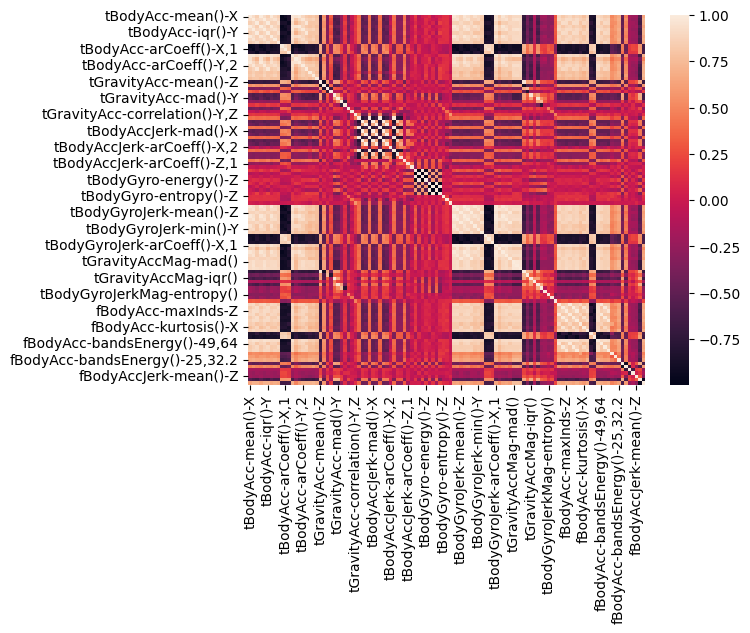

In [36]:
sns.heatmap(transformed_df_train_2.corr())

#### ANOVA

**ANOVA** (Analysis of Variance) is a statistical method commonly used for feature selection in machine learning. It evaluates the relationship between input features and the target variable by comparing the variance within groups to the variance between groups. This method is particularly effective for selecting features in datasets with categorical independent variables and continuous dependent variables. Advantages include simplicity, speed, and effectiveness in identifying significant features. However, ANOVA assumes normality and independence of data, making it less suitable for non-linear relationships or dependent datasets. Additionally, it cannot handle interactions between features, which may limit its utility in complex models.

In [37]:
# Instantiate the pipeline
pipeline = Pipeline([
    ('remove_duplicates', DuplicateColumnRemover()),
    ('variance_threshold', VarianceThreshold(threshold=0.05)),
    ('correlation_remover', CorrelationThresholdRemover(threshold=0.9)),
    ('Anova_selector', SelectKBest(f_classif, k=100))
])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('remove_duplicates', DuplicateColumnRemover()),
                ('variance_threshold', VarianceThreshold(threshold=0.05)),
                ('correlation_remover', CorrelationThresholdRemover()),
                ('Anova_selector', SelectKBest(k=100))])

In [38]:
transformed_X_train_3 = pipeline.transform(X_train)

In [39]:
transformed_X_train_3

array([[-0.9944254 , -0.99487263, -0.99488582, ..., -0.28695881,
         0.14991895, -0.21788456],
       [-0.32633148,  0.0696628 , -0.22432128, ...,  0.28436994,
        -0.62512809,  0.66284691],
       [-0.02621997, -0.03216306,  0.39310852, ...,  0.25585659,
         0.01686076,  0.02270385],
       ...,
       [-0.62719763, -0.21656585, -0.42476369, ...,  0.34451615,
        -0.43457906,  0.30169739],
       [-0.9948248 , -0.98531367, -0.96585729, ..., -0.25219342,
         0.23553996, -0.15752001],
       [-0.36865452, -0.14263084, -0.15125003, ...,  0.22766867,
        -0.48621609,  0.43371953]])

In [40]:
transformed_X_train_3.shape

(5881, 100)

In [41]:

# Get the selected feature indices
selected_indices = pipeline.named_steps['Anova_selector'].get_support(indices=True)

# Get the original feature names using the selected indices
selected_feature_names = X_train.columns[selected_indices]

# Convert the result to a list of feature names
selected_feature_names_list = selected_feature_names.tolist()

print(selected_feature_names_list)

['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-min()-Z', 'tBodyAcc-sma()', 'tBodyAcc-energy()-X', 'tBodyAcc-energy()-Y', 'tBodyAcc-energy()-Z', 'tBodyAcc-iqr()-X', 'tBodyAcc-iqr()-Y', 'tBodyAcc-iqr()-Z', 'tBodyAcc-entropy()-X', 'tBodyAcc-entropy()-Y', 'tBodyAcc-entropy()-Z', 'tBodyAcc-arCoeff()-X,1', 'tBodyAcc-arCoeff()-X,4', 'tBodyAcc-arCoeff()-Y,2', 'tBodyAcc-arCoeff()-Y,3', 'tBodyAcc-arCoeff()-Y,4', 'tBodyAcc-arCoeff()-Z,1', 'tBodyAcc-arCoeff()-Z,2', 'tBodyAcc-arCoeff()-Z,3', 'tBodyAcc-arCoeff()-Z,4', 'tBodyAcc-correlation()-X,Y', 'tBodyAcc-correlation()-X,Z', 'tBodyAcc-correlation()-Y,Z', 'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-mean()-Z', 'tGravityAcc-std()-X', 'tGravityAcc-std()-Y', 'tGravityAcc-std()-Z', 'tGravityAcc

In [42]:
transformed_df_train_3 = pd.DataFrame(transformed_X_train_3, columns = selected_feature_names_list)
transformed_df_train_3

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4"
0,-0.994425,-0.994873,-0.994886,-0.994939,-0.993994,-0.995450,-0.938974,-0.577031,-0.813863,0.846922,...,-0.999230,-0.994241,-0.982647,-0.896017,-0.430368,-0.622629,0.338619,-0.286959,0.149919,-0.217885
1,-0.326331,0.069663,-0.224321,-0.343326,0.039623,-0.256327,-0.310961,0.085617,-0.411806,0.271334,...,-0.587510,-0.533524,0.089042,0.870400,-0.134031,0.000865,-0.287847,0.284370,-0.625128,0.662847
2,-0.026220,-0.032163,0.393109,-0.118256,-0.030279,0.432861,0.370607,-0.072309,0.200747,0.118277,...,-0.523668,0.146709,-0.538377,0.691959,-0.238478,0.200254,-0.484592,0.255857,0.016861,0.022704
3,-0.981092,-0.901124,-0.960423,-0.984417,-0.901405,-0.965788,-0.922291,-0.524676,-0.807362,0.825370,...,-0.888504,-0.949650,-0.899405,0.150955,-0.220464,0.170012,-0.603770,0.389099,-0.267228,0.091483
4,-0.997380,-0.983893,-0.984482,-0.997331,-0.985196,-0.983768,-0.942062,-0.564033,-0.810993,0.853330,...,-0.984785,-0.988533,-0.990783,-0.286130,-0.542528,-0.323641,-0.365228,0.284003,-0.118201,0.118660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,-0.555352,-0.104055,-0.438064,-0.572530,-0.112149,-0.429688,-0.479744,-0.077885,-0.373579,0.454289,...,-0.349193,-0.529392,-0.584657,0.038441,0.065154,0.306949,-0.702010,0.395776,-0.485000,0.427826
5877,-0.290043,-0.212102,-0.469731,-0.307317,-0.209558,-0.528635,-0.283244,-0.017039,-0.123285,0.123907,...,-0.465233,-0.507642,-0.659972,0.156262,0.342386,0.301551,-0.557796,0.351891,-0.342990,0.092538
5878,-0.627198,-0.216566,-0.424764,-0.648666,-0.253814,-0.417569,-0.547082,-0.236201,-0.441355,0.530629,...,-0.385185,-0.687471,-0.663692,0.163029,0.158676,0.096314,-0.586953,0.344516,-0.434579,0.301697
5879,-0.994825,-0.985314,-0.965857,-0.995170,-0.984285,-0.963293,-0.937503,-0.570198,-0.805684,0.849776,...,-0.994079,-0.988709,-0.994512,-0.429390,-0.479023,-0.448591,0.294839,-0.252193,0.235540,-0.157520


In [43]:
transformed_X_test_3 = pipeline.transform(X_test)

In [44]:
transformed_df_test_3 = pd.DataFrame(transformed_X_test_3, columns = selected_feature_names_list)
transformed_df_test_3

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4"
0,0.384949,0.176898,-0.310332,0.381757,0.122611,-0.332984,0.465563,0.023174,-0.274788,-0.176416,...,-0.150730,-0.459320,-0.261615,0.184981,0.271911,0.286356,-0.223335,0.110039,-0.102322,0.110694
1,0.201409,-0.154142,0.344183,0.092771,-0.182114,0.291899,0.586004,-0.089706,-0.307547,0.201299,...,-0.254111,-0.347548,-0.481854,0.030968,0.165670,0.326082,-0.350091,0.233805,-0.382423,0.422816
2,-0.336609,-0.279162,-0.303323,-0.381421,-0.253026,-0.337381,0.074430,-0.228225,-0.346372,0.339322,...,-0.671892,-0.725761,-0.434907,0.298881,0.061093,0.305446,-0.293485,0.240893,-0.321473,0.257481
3,-0.992196,-0.982169,-0.981127,-0.992838,-0.981366,-0.979864,-0.931924,-0.560341,-0.809997,0.840250,...,-0.989887,-0.964956,-0.951861,-0.854935,-0.978712,0.440352,-0.134809,0.045370,-0.010127,0.033641
4,0.075014,0.046502,-0.369482,-0.024794,-0.085337,-0.385018,0.562230,0.093312,-0.200019,0.213969,...,-0.247276,-0.288654,-0.390260,0.339110,0.316071,0.259035,-0.366455,0.260950,-0.257895,0.293059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,-0.947145,-0.835807,-0.895158,-0.954108,-0.852196,-0.903123,-0.847094,-0.408376,-0.785863,0.830999,...,-0.978327,-0.975270,-0.799356,0.245330,0.420631,0.872287,0.192061,-0.123166,0.124545,-0.092449
1467,-0.975745,-0.876568,-0.932322,-0.984813,-0.901080,-0.944801,-0.862074,-0.454572,-0.779758,0.828468,...,-0.956360,-0.982021,-0.958804,-0.519595,-0.109715,-0.124828,-0.587459,0.404213,-0.304608,0.203904
1468,-0.994198,-0.988329,-0.990618,-0.994584,-0.987081,-0.990640,-0.936933,-0.569781,-0.823135,0.848724,...,-0.994891,-0.994884,-0.976871,-0.467303,-0.169114,-0.144376,0.079509,-0.167669,0.263227,-0.264401
1469,-0.997517,-0.982207,-0.974343,-0.997900,-0.985061,-0.971293,-0.938729,-0.555729,-0.804258,0.851457,...,-0.997669,-0.988155,-0.996823,-0.677332,-0.284305,-0.588973,0.060095,-0.066923,0.525819,-0.439976


#### Final Test after Feature Selection

In [45]:
# Initialize and train logistic regression model
log_reg = LogisticRegression(max_iter=2500)  # Increase max_iter if it doesn't converge
log_reg.fit(transformed_df_train_3, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(transformed_X_test_3)

# Calculate and print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Test accuracy: 0.9653297076818491


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


With 563 features, the accuracy is 98% whereas with just 100 features, the accuracy is 96.5% which is much preferable regarding computational and time complexity of the model.

#### Chi-Square

The **Chi-square method** is a statistical technique used for feature selection, particularly effective for categorical data. It evaluates the dependency between features and the target variable by calculating the Chi-square statistic. Features with higher Chi-square scores are considered more relevant. This method is simple, computationally efficient, and effective for filtering out irrelevant or redundant features in classification tasks. Advantages include its ease of implementation and suitability for discrete data. However, the Chi-square method assumes independence between observations, which may not hold in some datasets. It also cannot handle continuous features without discretization, potentially leading to information loss. Furthermore, it evaluates each feature individually, ignoring potential interactions, which might affect its effectiveness in identifying complex relationships.

In [46]:
titanic = pd.read_csv('/kaggle/input/titanic/train.csv')[['Pclass','Sex','SibSp','Parch','Embarked','Survived']]
titanic.head()

,Pclass,Sex,SibSp,Parch,Embarked,Survived
0,3,male,1,0,S,0
1,1,female,1,0,C,1
2,3,female,0,0,S,1
3,1,female,1,0,S,1
4,3,male,0,0,S,0


In [47]:
ct = pd.crosstab(titanic['Survived'],titanic['Sex'],margins=True)
ct

Sex,female,male,All
Survived,,,
0,81,468,549
1,233,109,342
All,314,577,891


In [48]:
from scipy.stats import chi2_contingency
chi2_contingency(ct)

Chi2ContingencyResult(statistic=263.05057407065567, pvalue=1.0036732821369117e-55, dof=4, expected_freq=array([[193.47474747, 355.52525253, 549.        ],
       [120.52525253, 221.47474747, 342.        ],
       [314.        , 577.        , 891.        ]]))

In [49]:
score = []

for feature in titanic.columns[:-1]:
    
    # create contingency table
    ct = pd.crosstab(titanic['Survived'], titanic[feature])
    
    # chi_test
    p_value = chi2_contingency(ct)[1]
    score.append(p_value)

<Axes: >

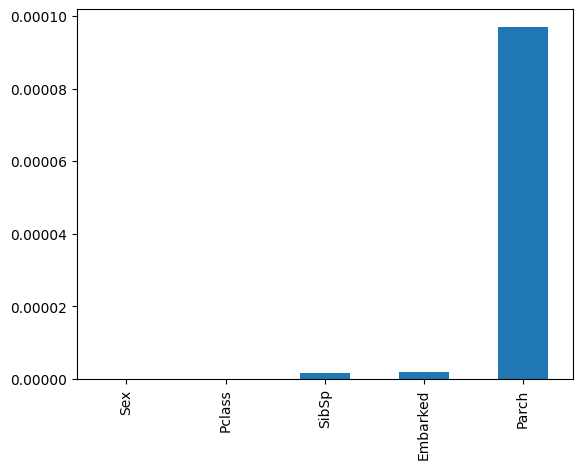

In [50]:
pd.Series(score, index=titanic.columns[:-1]).sort_values(ascending=True).plot(kind='bar')


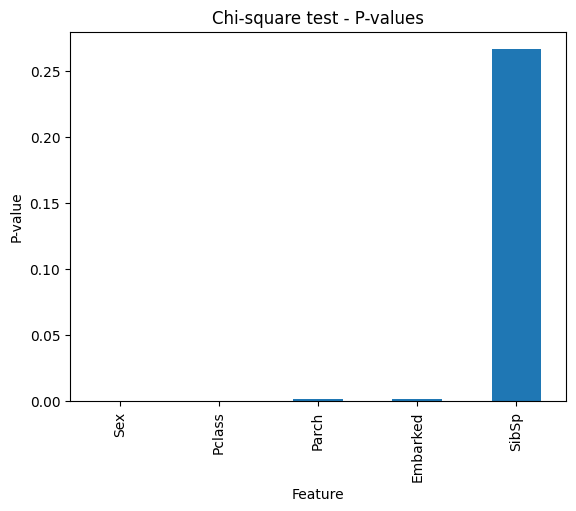

In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt

# assuming titanic is your DataFrame and 'Survived' is the target column

# Encode categorical variables
le = LabelEncoder()
titanic_encoded = titanic.apply(le.fit_transform)

X = titanic_encoded.drop('Survived', axis=1)
y = titanic_encoded['Survived']

# Calculate chi-squared stats
chi_scores = chi2(X, y)

# chi_scores[1] are the p-values of each feature.
p_values = pd.Series(chi_scores[1], index = X.columns)
p_values.sort_values(inplace = True)

# Plotting the p-values
p_values.plot.bar()

plt.title('Chi-square test - P-values')
plt.xlabel('Feature')
plt.ylabel('P-value')

plt.show()